In [2]:
import os
import PIL
import numpy as np
import pandas as pdf
from torch.utils.data import Dataset

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Utility Functions

In [3]:
#Function for showing images
def imshow(img):
    #img = img / 2 + 0.5  
    #print(img)
    #plt.imshow can take in images with 0-1 (floats) or 0-255 (int)
    plt.imshow(np.transpose(img, (1, 2, 0))) 
    #print(img)
    #print(max(img[0][0]))
    print(np.mean(img[0][2]))
    print(np.std(img[0][2]))
    #print(max(img[0][1]))
    #print(max(img[0][2]))
#It's best to keep the data processing code separate from the class loader
def to_tensor_and_normalize(imagepil): #Done with testing
    """Convert image to torch Tensor and normalize using the ImageNet training
    set mean and stdev taken from
    https://pytorch.org/docs/stable/torchvision/models.html.
    Why the ImageNet mean and stdev instead of the PASCAL VOC mean and stdev?
    Because we are using a model pretrained on ImageNet."""
    #Think the reason for introducing normalisation is because of the imagenet weights
    #ChosenTransforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    #            torchvision.transforms.Normalize(mean=[0.6236, 0.5118, 0.4264],std=[0.3545, 0.2692, 0.3376]),])


    #This straight up just transforms 0-255 to 0-1
    ChosenTransforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])#, torchvision.transforms.Normalize(mean=[0.3, 0.3, 0.3],std=[0.05, 0.05, 0.05])])
    #ChosenTransforms = torchvision.transforms.Compose([torchvision.transforms.PILToTensor()])#[torchvision.transforms.ToTensor()])
    """ChosenTransforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                      lambda x: x*1.666666666666666666667,
                                                      ])"""
    return ChosenTransforms(imagepil)

# Class for loading in my simulated image training data

In [4]:
class SimData(Dataset):
    def __init__(self, setname):
        '''The sim input images and output images are 128 x 128 x 3'''
        self.setname = setname
        assert setname in ['train','val','test']
        
        #Define where to load in the dataset
        overall_dataset_dir = os.path.join(os.path.join(os.getcwd(),'load_dataset'), 'data')
        #input images
        self.selected_dataset_dir = os.path.join(overall_dataset_dir,setname)
        
        #output images
        self.selected_dataset_output_dir = os.path.join(overall_dataset_dir,setname+"_outputs")
        
        #E.g. self.all_filenames = ['im1.jpg',..,'imN.jpg'] when setname=='train'
        #Loads in the input images from the training folder
        self.all_filenames = os.listdir(self.selected_dataset_dir)
        self.all_filenames_output = os.listdir(self.selected_dataset_output_dir)
        
    def __len__(self):
        """Return the total number of examples in this split, e.g. if
        self.setname=='train' then return the total number of examples
        in the training set"""
        return len(self.all_filenames)
    
    def __getitem__(self,idx):
        """Return the example at index [idx]. The example is a dict with keys
        'data' (value: Tensor for an RGB image) and labels are also images"""
        #For the inputs
        selected_filename = self.all_filenames[idx]
        #print(selected_filename)
        #test= self.all_filenames_output[idx]
        #print(test)
        imagepil = PIL.Image.open(os.path.join(self.selected_dataset_dir,selected_filename)).convert('RGB')
        
        #For the outputs
        selected_filename_output = self.all_filenames_output[idx]
        imagepil_output = PIL.Image.open(os.path.join(self.selected_dataset_output_dir,
                                                      selected_filename_output)).convert('RGB')
        
        #convert image to Tensor/normalize
        image = to_tensor_and_normalize(imagepil)
        image_output = to_tensor_and_normalize(imagepil_output)
        
        
        sample = {'data':image, #preprocessed image, for input into NN
                  'label':image_output,
                  'img_idx':idx}
        
        return sample

# Now to load in the dataset

In [5]:
#Basically load the created class in
train_dataset = SimData("train")

#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle = False)

# Display the loaded in images for a sanity check lol

Input Images (Sensor Data)
0.35882354
0.051074572
0.3659314
0.057270657
0.36320466
0.05833358
0.36424634
0.049707476
0.36415443
0.0551176


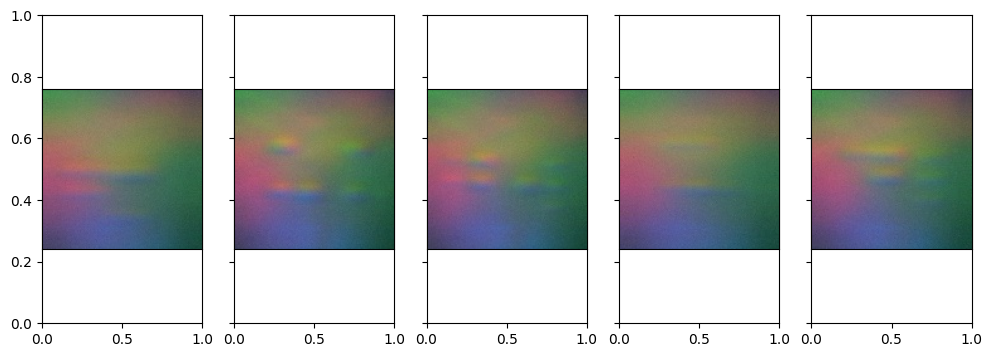

Shape output Images
0.3645527
0.060497824
0.36838233
0.05979739
0.36602327
0.059322383
0.36666667
0.059013173
0.3657782
0.059313145


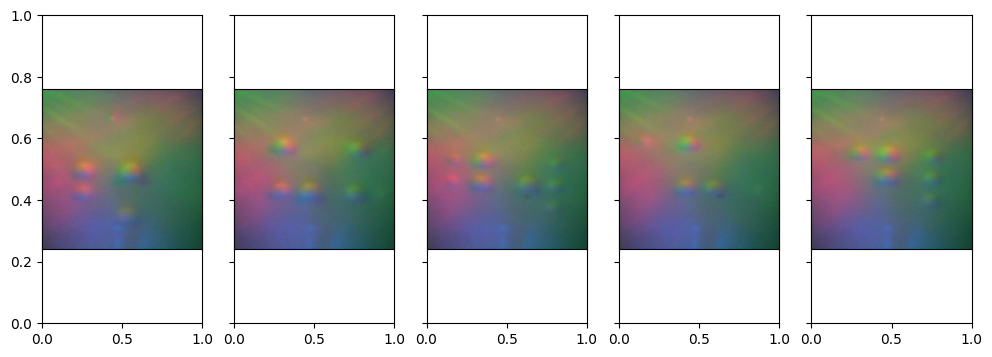

In [6]:
dataiter = iter(train_loader)
#For some reason this is needed
output = next(dataiter)
images = output['data'].numpy()
labels = output['label'].numpy()
#print(labels)
#Rather than this
#images, labels, _ = next(dataiter)
#images = images.numpy() # convert images to numpy for display


#Plot the images
print("Input Images (Sensor Data)")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])
plt.show()

#Output images
print("Shape output Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(labels[idx])
    #ax.set_title(classes[labels[idx]])
plt.show() 
    

In [7]:
print(images[0].shape)
print(labels[0].shape)
print(images[0])
print(np.max(images[0][1]))
print(np.mean(images[0][1]))

(3, 128, 128)
(3, 128, 128)
[[[0.25490198 0.2509804  0.24705882 ... 0.32941177 0.30980393 0.3137255 ]
  [0.25882354 0.2509804  0.24313726 ... 0.3254902  0.3137255  0.31764707]
  [0.27450982 0.27058825 0.27058825 ... 0.34117648 0.31764707 0.3372549 ]
  ...
  [0.28235295 0.27450982 0.2901961  ... 0.11764706 0.12156863 0.10196079]
  [0.25882354 0.28235295 0.2784314  ... 0.09803922 0.09411765 0.1254902 ]
  [0.27058825 0.2784314  0.28627452 ... 0.10980392 0.10980392 0.09803922]]

 [[0.54901963 0.54509807 0.5411765  ... 0.27058825 0.2509804  0.25490198]
  [0.5529412  0.54901963 0.5372549  ... 0.26666668 0.25490198 0.25882354]
  [0.5647059  0.56078434 0.56078434 ... 0.28235295 0.25882354 0.2784314 ]
  ...
  [0.26666668 0.25882354 0.27450982 ... 0.30588236 0.30980393 0.2901961 ]
  [0.24313726 0.26666668 0.2627451  ... 0.28627452 0.28235295 0.3137255 ]
  [0.25490198 0.2627451  0.27058825 ... 0.29803923 0.29803923 0.28627452]]

 [[0.31764707 0.3137255  0.30980393 ... 0.34509805 0.3254902  0.3294

#  Conv autoencoder

In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self, layer_disp = False):
        super(ConvAutoencoder, self).__init__()
        self.layer_disp = layer_disp
        #Encoder
        #nn.Conv2(in_channels, out_channels, kernel_size, stride, padding)
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=128,
                               kernel_size=2, 
                               stride = 1,
                               padding = 'same')
        self.conv2 = nn.Conv2d(in_channels=128, 
                               out_channels=256,
                               kernel_size=2, 
                               stride = 2,
                               padding = 0)
        
        self.conv3 = nn.Conv2d(in_channels=256, 
                               out_channels=256,
                               kernel_size=4, 
                               stride = 4,
                               padding = 0)
        
        
        
        self.pool = nn.MaxPool2d(2,2)
        
       
        #Decoder
        #nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.t_conv1 = nn.ConvTranspose2d(in_channels=256, 
                               out_channels=128,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        self.t_conv2= nn.ConvTranspose2d(in_channels=128, 
                               out_channels=128,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        self.t_conv3= nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        
        self.t_conv4= nn.ConvTranspose2d(in_channels=64, 
                               out_channels=64,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        self.t_conv5= nn.ConvTranspose2d(in_channels=64, 
                               out_channels=32,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        '''self.t_conv6= nn.ConvTranspose2d(in_channels=32, 
                               out_channels=32,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)'''
       
        self.t_convout = nn.ConvTranspose2d(in_channels=32, 
                               out_channels=3,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        #self.upsample = nn.functional.interpolate(scale_factor = 2)


    def forward(self, x):
        en_layer1 = F.relu(self.conv1(x))   
        en_layer1 = self.pool(en_layer1)
        en_layer2 = F.relu(self.conv2(en_layer1))
        en_layer2 = self.pool(en_layer2)
        en_layer3 = F.relu(self.conv3(en_layer2))
        en_layer3 = self.pool(en_layer3)

        #de_layer0 = F.relu(self.t_conv0(en_layer4)) 
        de_layer1 = F.relu(self.t_conv1(en_layer3))   
        #de_layer1 = nn.functional.interpolate(de_layer1,scale_factor = 2)
        de_layer2= F.relu(self.t_conv2(de_layer1)) 
        de_layer3= F.relu(self.t_conv3(de_layer2))
        de_layer4= F.relu(self.t_conv4(de_layer3))
        de_layer5= F.relu(self.t_conv5(de_layer4))
        #de_layer6= F.relu(self.t_conv6(de_layer5))
        
        #de_layerout = torch.sigmoid(self.t_conv3(de_layer2))
        de_layerout = F.relu(self.t_convout(de_layer5))
        #de_layerout = self.t_conv5(de_layer4)
        
        if self.layer_disp:
            print("input", x.shape)
            print("en_layer1",en_layer1.shape)
            #print("en_layer1a",en_layer1a.shape)
            print("en_layer2",en_layer2.shape)
            #print("en_layer2a",en_layer2a.shape)
            print("en_layer3",en_layer3.shape)
            #print("en_layer3a",en_layer3a.shape)
            #print("en_layer4",en_layer4.shape)
            #print("en_layer5",en_layer5.shape)
            
            #print("de_layer0",de_layer0.shape)
            print("de_layer1",de_layer1.shape)
            #print("de_layer1a",de_layer1a.shape)
            print("de_layer2",de_layer2.shape)
            print("de_layer3",de_layer3.shape)
            print("de_layer4",de_layer4.shape)
            print("de_layer5",de_layer5.shape)
            #print("de_layer6",de_layer6.shape)
            #print("de_layer2a",de_layer2a.shape)
            #print("de_layer3",de_layerou.shape)
            #print("de_layer3a",de_layer3a.shape)
            #print("de_layer4",de_layer4.shape)
            print("de_layerout",de_layerout.shape)
              
        return de_layerout

In [9]:
#Now to intialise the model and shit
model = ConvAutoencoder(layer_disp = False).to(device)
model = ConvAutoencoder(layer_disp = True).to(device)

#Defining the loss function between the input and the output
#criterion = nn.BCELoss()
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma=0.2)

#This is just for testing and seeing the outputs of each convolutional layer
dummy = model(torch.empty(3, 128, 128).to(device))
#from torchviz import make_dot
#make_dot(dummy, params=dict(list(model.named_parameters()))).render("autoencoder", format="png")




input torch.Size([3, 128, 128])
en_layer1 torch.Size([128, 64, 64])
en_layer2 torch.Size([256, 16, 16])
en_layer3 torch.Size([256, 2, 2])
de_layer1 torch.Size([128, 4, 4])
de_layer2 torch.Size([128, 8, 8])
de_layer3 torch.Size([64, 16, 16])
de_layer4 torch.Size([64, 32, 32])
de_layer5 torch.Size([32, 64, 64])
de_layerout torch.Size([3, 128, 128])


/home/parth/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


# Train the model

In [10]:
# from livelossplot import PlotLosses

# n_epochs = 10000 #Number of epochs

# liveloss = PlotLosses()
# logs = {}


# for epoch in range(1, n_epochs+1):
#     # monitor training loss
#     train_loss = 0.0

#     #Training
#     for data in train_loader:
#         #For some reason this is needed
#         output = data
#         #print(output)
#         images = output['data']
#         labels = output['label']
#         #images, _ = data #Don't care about the labels
#         images = images.to(device) 
#         labels = labels.to(device) 
#         optimizer.zero_grad()
#         outputs = model(images)
#         #outputs = model(labels) #to test if the autoencoder works
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()*images.size(0)
          
#     train_loss = train_loss/len(train_loader)
#     logs['loss'] = train_loss
    
#     #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
#     predictions = outputs
#     predictions = predictions.detach().cpu().numpy()
#     imshow(predictions[0])
#     if not(epoch%50) or epoch ==0:
#         plt.show()

#     liveloss.update(logs)
#     liveloss.send()
    

# Display the predictions

In [11]:
#import the trainined model from pth file and set for inference
model.load_state_dict(torch.load('/home/parth/UROP_2023/deblur.pth', map_location=torch.device('cpu')))
model.eval()

train_dataset = train_dataset = SimData("test")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle = True)


#Batch of test images
with torch.no_grad():
    dataiter = iter(train_loader)
    #images, labels = next(dataiter)
    output = next(dataiter)
    images = output['data'].to(device) #these are the inputs
    #labels = output['label'].to(device)
    #labels = output['label'].numpy() #again labels aren't needed

    #Sample outputs
    #predictions = model(labels) #test just the atoencoder ibit
    predictions = model(images) #output of the network
    images = images.detach().cpu().numpy() #convert the images back to numpy arrays
    #labels = labels.detach().cpu().numpy() #convert the images back to numpy arrays

    #convert back to appropriate numpy array and shit
    print(images.shape)
    print(predictions.shape)
    predictions = predictions.detach().cpu().numpy()
    #predictions = predictions.view(batch_size, 3, 32, 32)


    #Original Images
    print("Sensor Input")
    fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
    for idx in np.arange(5):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        #ax.set_title(classes[labels[idx]])
    plt.show()
    """
    #Original Images
    print("Real Shape Images")
    fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
    for idx in np.arange(5):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        imshow(labels[idx])
        #ax.set_title(classes[labels[idx]])
    plt.show()
    """
    #Reconstructed Images
    print('Reconstructed Predicted Shape Images')
    fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
    for idx in np.arange():
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        imshow(predictions[idx])
        #ax.set_title(classes[labels[idx]])
    plt.show() 

FileNotFoundError: [Errno 2] No such file or directory: '/home/parth/UROP_2023/autoencoder/load_dataset/data/test'

# Use Autoencoder on real row data and return braille symbols

In [ ]:
import cv2
from digit_demo import DigitSensor, DisplayImage
import kg_robot as kgr
import time
import os
from threading import Thread
import csv
import random

total_rows = 1 #set approx dataset size
dynamic_count = 1
row_counter = 1

z_depth = 0.0149 #set z depth of sensor, with medical tape need to be lower for clarity
y_offset = -0.27 #set y offset of sensor

velocity = 0 #initialise velocity
start = 0
time_list = []
slide_capture_flag = False #initialise slide capture flag

with (DigitSensor(serialno='D20654', resolution='QVGA', framerate='60') as digit,
            DisplayImage(window_name='DIGIT Demo') as display): #use wrapper to make accessing DIGIT sensor easier
    frame = digit.get_frame()
    print("------------Configuring brailley------------\r\n")
    brailley = kgr.kg_robot(port=30000,db_host="169.254.252.50")
    print("----------------Hi brailley!----------------\r\n\r\n")

    def read_camera(): #function to read camera
         global frame
         global start, time_list
         while True:
            frame = digit.get_frame() #get frame from camera
            if slide_capture_flag == True: 
                t1 = time.time() - start
                capture_frame("autoencoder/load_dataset/data/test") #capture frame
                t2 = time.time() - start
                time_of_capture = (t1+t2)/2 #average time of capture
                time_list.append(time_of_capture)

    def capture_frame(dir_path): #function to capture frame and save it
        global static_collect, dynamic_collect, static_count, dynamic_count
        os.makedirs(dir_path, exist_ok=True)  
        base_path = os.path.join(dir_path,"im{}.jpg".format(dynamic_count)) #create path to save frame

        # resize the images for autoencoder
        new_size = (128, 128) # new_size=(width, height)
        frame = cv2.resize(frame, new_size)
        cv2.imwrite(base_path, frame)
        dynamic_count += 1 #increment counts
    
    def move_robot(): #fixed movements for each data collection step
        global dynamic_count, velocity, row_counter
        global slide_capture_flag
        global start, time_list

        time_list = [] #reset time list
        start = time.time()
        slide_capture_flag = True
        brailley.movel([0.169, y_offset, z_depth,  2.21745, 2.22263, -0.00201733], 500, velocity) #slide across one row
        slide_capture_flag = False
        time.sleep(0.5)
        scroll_button() #press scroll button
        with open('test_time_list.csv', 'a') as f: #append string of letters, velocity and times to csv
                write = csv.writer(f)
                time_list.insert(0, velocity) #insert velocity at start of list
                with open('training.txt', 'r') as f:
                    doc = f.read()
                    row_string = doc[(20*row_counter):(20*row_counter) +20] #get string of letters for each row
                    time_list.insert(0, row_string) #insert string of letters at start of list
                    row_counter += 1
                write.writerow(time_list) #write row to csv

    def scroll_button():
        brailley.movel([0.15, -0.261243, 0.0200194, 2.09817, 2.33561, -0.00188124], 0.5, 0.2) #move to scroll position
        time.sleep(0.5)
        brailley.translatel_rel([0, 0, -0.006, 0, 0, 0], 0.5, 0.2) #press scroll button
        time.sleep(0.5)
        brailley.translatel_rel([0, 0, 0.006, 0, 0, 0], 0.5, 0.2) #move back to scroll position
        time.sleep(0.5)
        brailley.movel([0.293484,y_offset, z_depth, 2.21745, 2.22263, -0.00201733], 0.5, 0.2) #move above first position
        time.sleep(0.5)
        brailley.movel([0.293484,y_offset, z_depth, 2.21745, 2.22263, -0.00201733], 0.5, 0.2) #move to first position

    def predict_deblur(): #function to predict deblurred images using trainined autoencoder
        global row_counter, dynamic_count

        test_dataset = SimData("test")
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=0, shuffle = True)

        test_size = 0
        # Iterate directory
        for path in os.listdir("autoencoder/load_dataset/data/test"):
            # check if current path is a file
            if os.path.isfile(os.path.join("autoencoder/load_dataset/data/test", path)):
                test_size += 1

        #Batch of test images
        with torch.no_grad():
            dataiter = iter(test_loader)
            output = next(dataiter)
            images = output['data'].to(device) #these are the inputs
        
            predictions = model(images) #output of the network
            images = images.detach().cpu().numpy() #convert the images back to numpy arrays

            #convert back to appropriate numpy array and shit
            print(images.shape)
            print(predictions.shape)
            predictions = predictions.detach().cpu().numpy()

            #Original Images
            print("Sensor Input")
            fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
            for idx in np.arange(test_size):
                ax = fig.add_subplot(1, test_size, idx+1, xticks=[], yticks=[])
                imshow(images[idx])
                #ax.set_title(classes[labels[idx]])
            plt.show()

            #Reconstructed Images
            print('Reconstructed Predicted Shape Images')
            fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
            for idx in np.arange(test_size):
                ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
                imshow(predictions[idx])
                cv2.imwrite("autoencoder/load_dataset/data/test_outputs", np.transpose(predictions[idx], (1, 2, 0)))
                #ax.set_title(classes[labels[idx]])
            plt.show()
            
    def braille_reader(): #function to read braille in each frame
        #not sure exactly how to do this yet
        sentence = ""
        return sentence

    def performance_calc(predicted_text): #function to calculate performance of braille reader
        #not sure exactly how to do this yet
        error = 0
        return error


    if __name__=='__main__':
        t= Thread(target=read_camera) #start thread to read camera
        t.daemon = True #set thread to daemon so it closes when main thread closes
        t.start()
        
        brailley.movel([0.293484, y_offset, z_depth, 2.21745, 2.22263, -0.00201733], 0.5, 0.2) #move above first position
        time.sleep(0.5)
        brailley.movel([0.293484, y_offset, z_depth, 2.21745, 2.22263, -0.00201733], 0.5, 0.2) #move to first position
        time.sleep(0.5)

        with open('test_time_list.csv', 'w') as f:
                write = csv.writer(f) #create csv file to write to

        print("------------Starting data collection------------\r\n")

        while row_counter <= total_rows: #get at least the target data set size
            velocity = 0.4
            move_robot() #movements
            print("Row {} of {} collected".format(row_counter, total_rows)) #print progress

            predict_deblur() #predict the sharp frames for row

            predicted_text = braille_reader() #read braille in each frame

            print("Predicted text: {}".format(predicted_text))



print("------------Data collection complete------------\r\n")